
# Emcee and the Model Interface


*Note: This is not my work, this is instead an online tutorial, [Emcee and the Model Interface](https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html), that I used as a refence in tackling a question given to me in my course. -Felix Martinez*

In [1]:
import corner
import matplotlib.pyplot as plt
import numpy as np

import lmfit

Set up a double-exponential function and create a Model:



In [2]:
def double_exp(x, a1, t1, a2, t2):
    return a1*np.exp(-x/t1) + a2*np.exp(-(x-0.1) / t2)


model = lmfit.Model(double_exp)

Generate some fake data from the model with added noise:



In [3]:
truths = (3.0, 2.0, -5.0, 10.0)
x = np.linspace(1, 10, 250)
np.random.seed(0)
y = double_exp(x, *truths)+0.1*np.random.randn(x.size)

Create model parameters and give them initial values:



In [4]:
p = model.make_params(a1=4, t1=3, a2=4, t2=3)

Fit the model using a traditional minimizer, and show the output:



[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 609
    # data points      = 250
    # variables        = 4
    chi-square         = 2.33333982
    reduced chi-square = 0.00948512
    Akaike info crit   = -1160.54007
    Bayesian info crit = -1146.45423
[[Variables]]
    a1:  2.98623689 +/- 0.15010519 (5.03%) (init = 4)
    t1:  1.30993186 +/- 0.13449656 (10.27%) (init = 3)
    a2: -4.33525597 +/- 0.11765824 (2.71%) (init = 4)
    t2:  11.8240752 +/- 0.47172610 (3.99%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) = 0.988
    C(t1, a2) = -0.928
    C(t1, t2) = -0.885
    C(a1, t1) = -0.609
    C(a1, a2) = 0.297
    C(a1, t2) = 0.232


/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/lmfit/minimizer.py:184: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


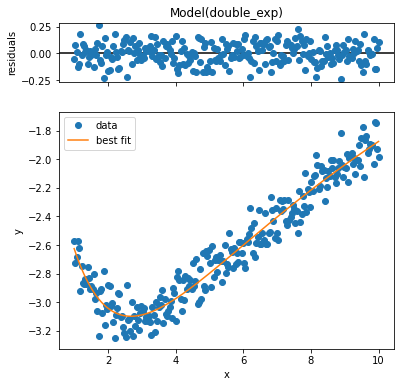

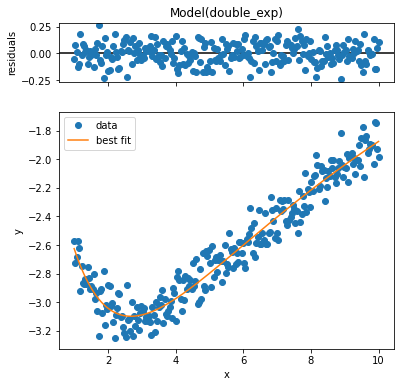

In [5]:
result = model.fit(data=y, params=p, x=x, method='Nelder', nan_policy='omit')

lmfit.report_fit(result)
result.plot()

Calculate parameter covariance using ``emcee``:

 - start the walkers out at the best-fit values
 - set ``is_weighted`` to ``False`` to estimate the noise weights
 - set some sensible priors on the uncertainty to keep the MCMC in check



In [6]:
emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

run the MCMC algorithm and show the results:



In [7]:
result_emcee = model.fit(data=y, x=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

In [8]:
lmfit.report_fit(result_emcee)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 250
    # variables        = 5
    chi-square         = 245.221790
    reduced chi-square = 1.00090526
    Akaike info crit   = 5.17553688
    Bayesian info crit = 22.7828415
[[Variables]]
    a1:         2.99546858 +/- 0.14834594 (4.95%) (init = 2.986237)
    t1:         1.32127391 +/- 0.14079400 (10.66%) (init = 1.309932)
    a2:        -4.34376940 +/- 0.12389335 (2.85%) (init = -4.335256)
    t2:         11.7937607 +/- 0.48879633 (4.14%) (init = 11.82408)
    __lnsigma: -2.32712371 +/- 0.04514314 (1.94%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) = 0.981
    C(t1, a2) = -0.937
    C(t1, t2) = -0.895
    C(a1, t1) = -0.515
    C(a1, a2) = 0.220
    C(a1, t2) = 0.187


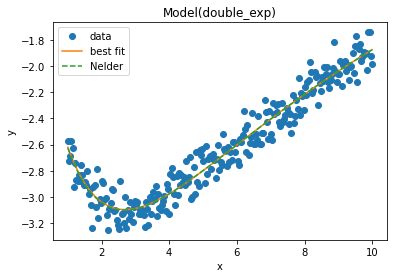

In [9]:
result_emcee.plot_fit()
plt.plot(x, model.eval(params=result.params, x=x), '--', label='Nelder')
plt.legend()

Check the acceptance fraction to see whether ``emcee`` performed well:



Text(0, 0.5, 'acceptance fraction')

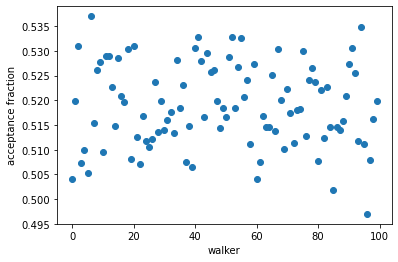

In [10]:
plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

Try to compute the autocorrelation time:



In [11]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result.params):
        print(f'{p} = {result_emcee.acor[i]:.3f}')

Autocorrelation time for the parameters:
----------------------------------------
a1 = 61.334
t1 = 85.867
a2 = 86.046
t2 = 84.745


Plot the parameter covariances returned by ``emcee`` using ``corner``:



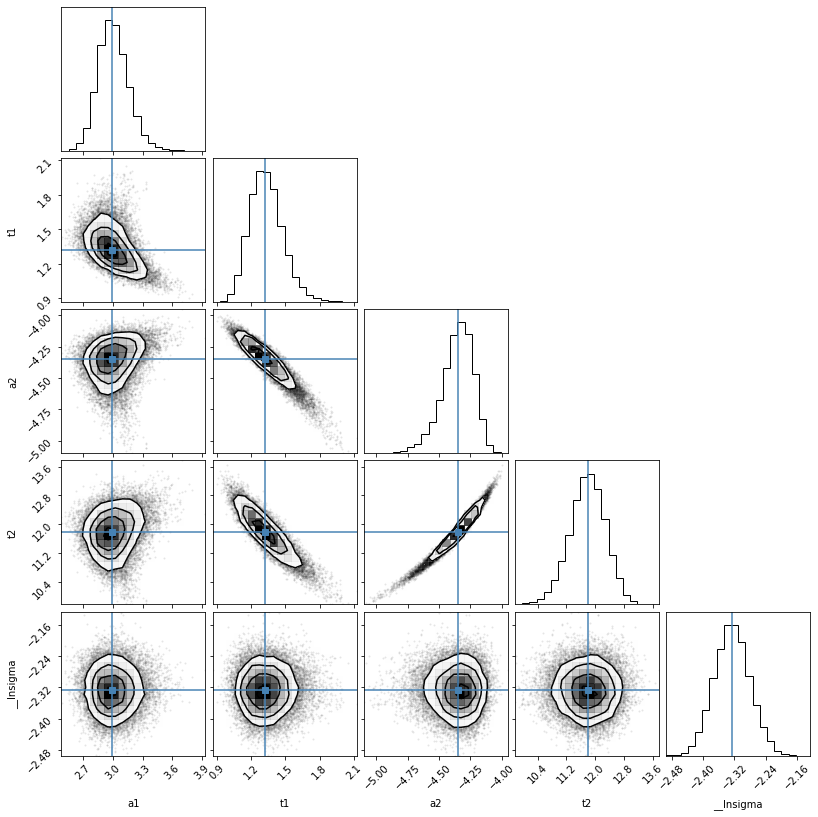

In [12]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [13]:
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    a1:         2.99546858 +/- 0.14834594 (4.95%) (init = 2.986237)
    t1:         1.32127391 +/- 0.14079400 (10.66%) (init = 1.309932)
    a2:        -4.34376940 +/- 0.12389335 (2.85%) (init = -4.335256)
    t2:         11.7937607 +/- 0.48879633 (4.14%) (init = 11.82408)
    __lnsigma: -2.32712371 +/- 0.04514314 (1.94%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) = 0.981
    C(t1, a2) = -0.937
    C(t1, t2) = -0.895
    C(a1, t1) = -0.515
    C(a1, a2) = 0.220
    C(a1, t2) = 0.187


Find the maximum likelihood solution:



In [14]:
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum Likelihood Estimation (MLE):")
print('----------------------------------')
for ix, param in enumerate(emcee_params):
    print(f"{param}: {mle_soln[ix]:.3f}")

quantiles = np.percentile(result_emcee.flatchain['t1'], [2.28, 15.9, 50, 84.2, 97.7])
print(f"\n\n1 sigma spread = {0.5 * (quantiles[3] - quantiles[1]):.3f}")
print(f"2 sigma spread = {0.5 * (quantiles[4] - quantiles[0]):.3f}")


Maximum Likelihood Estimation (MLE):
----------------------------------
a1: 2.971
t1: 1.317
a2: -4.336
t2: 11.815
__lnsigma: -2.336


1 sigma spread = 0.141
2 sigma spread = 0.291
